# Función de log-verosimilitud

La función de log-verosimilitud $l$ se define como el logaritmo de la función de verosimilitud $L$, es decir:

$$l(\Theta|x) = log (L(\Theta|x)) = \sum_{i=1}^nlog(f(x_i|\Theta))$$

donde la función de verosimilitud para un vector de parámetros $\Theta$ dada una muestra aleatoria $x$ con una distribución asumida, es definida como:

$$L(\Theta|x) = \prod_{i=1}^nf(x_i|\Theta)$$

y $f$ es la función de masa/densidad de la distribución de la cual se obtuvo $x$.

## Método de máxima verosimilitud para estimar parámetros

El método de máxima verosimilitud se usa para estimar los parámetros de una distribución. El objetivo de este método es encontrar los valores de $\Theta$ que maximizan $L$ o $l$ y los valores encontrados se representan por $\tilde{\Theta}$ o $\tilde{\Theta}_{ML}$
 .

In [1]:
import numpy as np
from numpy import exp
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.special import factorial
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import statsmodels.api as sm
from statsmodels.api import Poisson
from scipy import stats
from scipy.stats import norm
from statsmodels.iolib.summary2 import summary_col

# Contando multimillonarios

Treisman está interesado en estimar el número de multimillonarios en diferentes países.

El número de multimillonarios tiene un valor entero.

Por lo tanto, consideramos distribuciones que toman valores solo en los enteros no negativos.

(Esta es una razón por la cual la regresión de mínimos cuadrados no es la mejor herramienta para el problema actual, ya que la variable dependiente en la regresión lineal no está restringida a valores enteros)

Una distribución entera es la distribución de Poisson, cuya función de masa de probabilidad (pmf) es:

$$f(y|\mu) = \frac{\mu^y}{y!}e^{-\mu}, \quad y=0,1,2,....$$

Podemos trazar la distribución de Poisson sobre $y$ para diferentes valores de $\mu$ de la siguiente manera

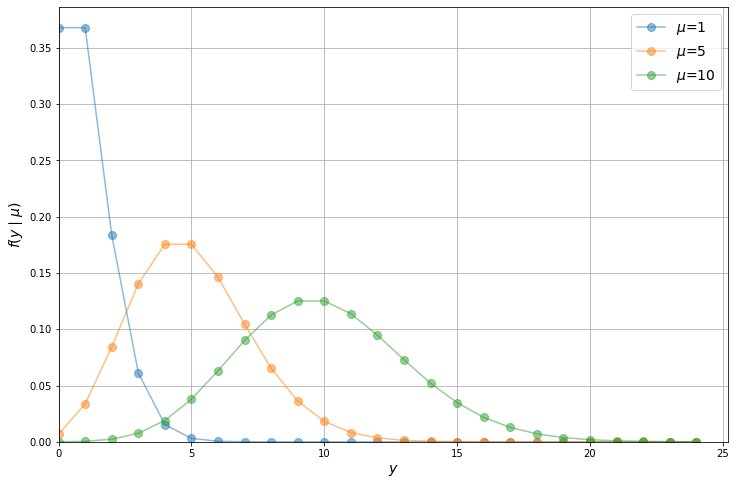

In [2]:
poisson_pmf = lambda y, μ: μ**y / factorial(y) * exp(-μ)

y_values = range(0, 25)

fig, ax = plt.subplots(figsize=(12, 8))

for μ in [1, 5, 10]:
    distribution = []
    for y_i in y_values:
        distribution.append(poisson_pmf(y_i, μ))
    ax.plot(y_values,
            distribution,
            label=f'$\mu$={μ}',
            alpha=0.5,
            marker='o',
            markersize=8)

ax.grid()
ax.set_xlabel('$y$', fontsize=14)
ax.set_ylabel('$f(y \mid \mu)$', fontsize=14)
ax.axis(xmin=0, ymin=0)
ax.legend(fontsize=14)

plt.show()

Observe que la distribución de Poisson comienza a parecerse a una distribución normal a medida que aumenta la media de $y$.

Echemos un vistazo a la distribución de los datos con los que trabajaremos en esta ayudantia.

La principal fuente de datos de Treisman es la clasificación anual de multimillonarios de Forbes y su patrimonio neto estimado.

El conjunto de datos fp.dta se puede descargar desde su página [AER](https://www.aeaweb.org/articles?id=10.1257/aer.p20161068).

In [3]:
pd.options.display.max_columns = 10

# Load in data and view
df = pd.read_stata('https://github.com/QuantEcon/lecture-source-py/blob/master/source/_static/lecture_specific/mle/fp.dta?raw=true')
df.to_excel('fp.xlsx', sheet_name='fp')
df.head()


,country,ccode,year,cyear,numbil,...,topint08,rintr,noyrs,roflaw,nrrents
0,United States,2.0,1990.0,21990.0,NaN,...,39.799999,4.988405,20.0,1.61,NaN
1,United States,2.0,1991.0,21991.0,NaN,...,39.799999,4.988405,20.0,1.61,NaN
2,United States,2.0,1992.0,21992.0,NaN,...,39.799999,4.988405,20.0,1.61,NaN
3,United States,2.0,1993.0,21993.0,NaN,...,39.799999,4.988405,20.0,1.61,NaN
4,United States,2.0,1994.0,21994.0,NaN,...,39.799999,4.988405,20.0,1.61,NaN


Usando un histograma, podemos ver la distribución de la cantidad de multimillonarios por país, **numbil0**, en 2008 (Estados Unidos se descartó para trazar)

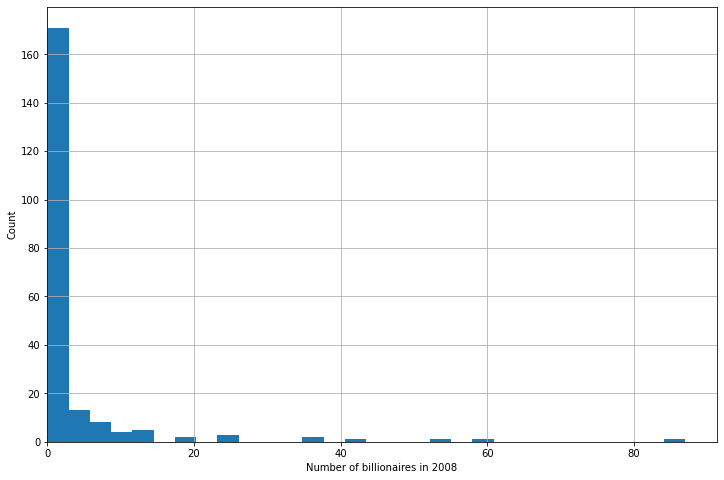

In [4]:
numbil0_2008 = df[(df['year'] == 2008) & (
    df['country'] != 'United States')].loc[:, 'numbil0']

plt.subplots(figsize=(12, 8))
plt.hist(numbil0_2008, bins=30)
plt.xlim(left=0)
plt.grid()
plt.xlabel('Number of billionaires in 2008')
plt.ylabel('Count')
plt.show()

Del histograma, parece que la suposición de Poisson no es irrazonable (aunque con un $\mu$ muy bajo y algunos valores atípicos).

# Distribuciones condicionales

En el documento de Treisman, la variable dependiente, el número de multimillonarios $y_i$ en el país $i$, se modela en función del PIB per cápita, el tamaño de la población y los años de membresía en el GATT (Acuerdo General sobre Aranceles Aduaneros y Comercio) y la OMC (Organizacion Mundial del Comercio).

Por lo tanto, la distribución de $y_i$ debe estar condicionada por el vector de variables explicativas $x_i$.

La formulación estándar, llamado modelo de regresión de Poisson, es la siguiente:

$$f(y_i|x_i) = \frac{\mu_i^{y_i}}{y_i!}e^{-\mu_i}; \quad y_i = 0,1,2,....$$

donde $\displaystyle \mu_i = e^{\beta_0 + \beta_1x_{i1} + ... + \beta_kx_{ik}}$

Para ilustrar la idea de que la distribución de $y_i$ depende de $x_i$, ejecutemos una simulación simple.

Utilizamos nuestra función **poisson_pmf** de arriba y valores arbitrarios para $\beta_i$ y $x_i$.

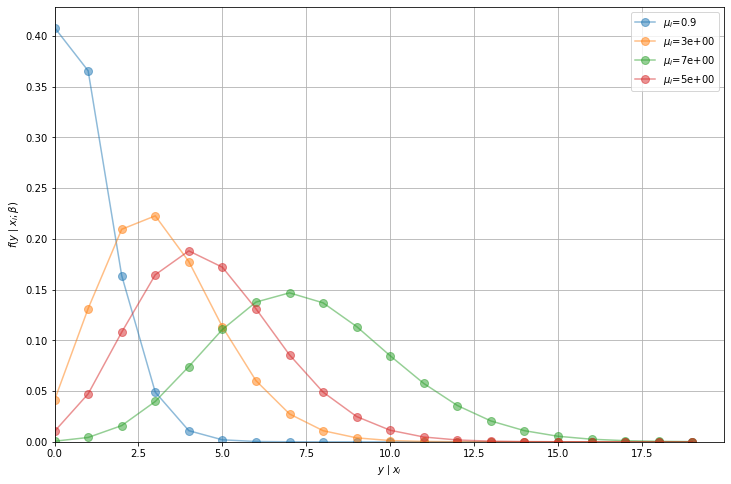

In [8]:
y_values = range(0, 20)

# Define a parameter vector with estimates
β = np.array([0.26, 0.18, 0.25, -0.1, -0.22])

# Create some observations X
datasets = [np.array([0, 1, 1, 1, 2]),
            np.array([2, 3, 2, 4, 0]),
            np.array([3, 4, 5, 3, 2]),
            np.array([6, 5, 4, 4, 7])]


fig, ax = plt.subplots(figsize=(12, 8))

# En Python 3.5, el operador @ se agregó como operador de infijo para la multiplicación de matrices

for X in datasets:
    μ = exp(X @ β)
    distribution = []
    for y_i in y_values:
        distribution.append(poisson_pmf(y_i, μ))
    ax.plot(y_values,
            distribution,
            label=f'$\mu_i$={μ:.1}',
            marker='o',
            markersize=8,
            alpha=0.5)

ax.grid()
ax.legend()
ax.set_xlabel('$y \mid x_i$')
ax.set_ylabel(r'$f(y \mid x_i; \beta )$')
ax.axis(xmin=0, ymin=0)
plt.show()

Podemos ver que la distribución de $y_i$ está condicionada a $x_i$ ($\mu_i$ ya no es constante).

# Estimación de máxima verosimilitud

En nuestro modelo para el número de multimillonarios, la distribución condicional contiene 4 (k = 4) parámetros que necesitamos estimar.

Vamos a etiquetar todo nuestro vector de parámetros como $\beta$ donde:

$$\beta = \left(
\begin{array}{c}
     \beta_0 
  \\ \beta_1
  \\ \beta_2 
  \\ \beta_3
\end{array}
\right)$$

Para estimar el modelo usando **MLE**, queremos maximizar la probabilidad de que nuestra estimación $\tilde{\beta}$ sea el verdadero parámetro $\beta$.

Intuitivamente, queremos encontrar el $\tilde{\beta}$ que mejor se adapte a nuestros datos.

Primero, necesitamos construir la función de probabilidad $L(\beta|y)$, que es similar a una función de densidad de probabilidad conjunta.

Supongamos que tenemos algunos datos $y_i = \{y_1, y_2\}$ y $y_i\sim f(y_i)$.

Si $y_1$ e $y_2$ son independientes, la pmf conjunta de estos datos es $f(y_1,y_2) = f(y1)\cdot f(y_2)$.

Si $y_i$ sigue una distribución de Poisson con $\mu = 7$, podemos visualizar la unión pmf así

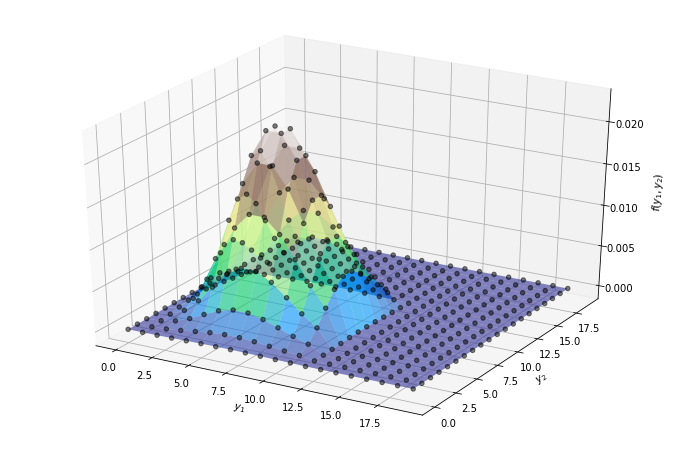

In [5]:
def plot_joint_poisson(μ=7, y_n=20):
    yi_values = np.arange(0, y_n, 1)

    # Create coordinate points of X and Y
    X, Y = np.meshgrid(yi_values, yi_values)

    # Multiply distributions together
    Z = poisson_pmf(X, μ) * poisson_pmf(Y, μ)

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z.T, cmap='terrain', alpha=0.6)
    ax.scatter(X, Y, Z.T, color='black', alpha=0.5, linewidths=1)
    ax.set(xlabel='$y_1$', ylabel='$y_2$')
    ax.set_zlabel('$f(y_1, y_2)$', labelpad=10)
    plt.show()

plot_joint_poisson(μ=7, y_n=20)

Del mismo modo, el pmf conjunta de nuestros datos (que se distribuye como una distribución de Poisson condicional) se puede escribir como:

$$f(y_1,y_2,...,y_n|x_1,x_2,...,x_k;\beta) = \prod_{i=1}^k\frac{\mu_i^{y_i}}{y_i!}e^{-\mu_i}$$

$y_i$ está condicionado tanto a los valores de $x_i$ como a los parámetros $\beta$.

La función de probabilidad es la misma que la pmf conjunta, pero trata el parámetro $\beta$ como una variable aleatoria y toma las observaciones $(y_i, x_i)$ como dadas

$$L(\beta|y_1,y_2,...,y_n;x_1,x_2,...,x_k) = \prod_{i=1}^n\frac{\mu_i^{y_i}}{y_i!}e^{-\mu_i} = f(y_1,y_2,...,y_n;x_1,x_2,...,x_k;\beta)$$

Ahora que tenemos nuestra función de probabilidad, queremos encontrar el $\tilde{\beta}$ que produce el valor de probabilidad máxima

$$\max_{\beta}L(\beta|\cdot)$$

Al hacerlo, generalmente es más fácil maximizar la probabilidad logarítmica (considere diferenciar $f(x) = x \cdot e^{(x)}$ frente a $\tilde{f}(x) = log(x) + x$).

Dado que tomar un logaritmo es una transformación monótona creciente, un maximizador de la función de verosimilitud también será un maximizador de la función de log-verosimilitud.

En nuestro caso, la probabilidad logarítmica es

$$\begin{array}{ccc}
     log L(\beta|\cdot) & =  &\displaystyle  log(f(y_1;X,\beta)\cdot f(y_2;X,\beta) \cdot ... \cdot f(y_n;X,\beta)) 
  \\ \ & = & \displaystyle \sum_{i=1}^nlog(f(y_i;X,\beta)) 
  \\  & = & \displaystyle \sum_{i=1}^n log(\frac{\mu_i^{y_i}}{y_i!}e^{-\mu_i})
  \\  & = & \displaystyle \sum_{i=1}^ny_ilog(\mu_i) - \sum_{i=1}^n\mu_i - \sum_{i=1}^nlog(y_i!)
\end{array} $$

El MLE de la Poisson para $\tilde{\beta}$ se puede obtener resolviendo

$$\max_{\beta} (\displaystyle \sum_{i=1}^ny_ilog(\mu_i) - \sum_{i=1}^n\mu_i - \sum_{i=1}^nlog(y_i!))$$

Sin embargo, no existe una solución analítica para el problema anterior: para encontrar el MLE necesitamos usar métodos numéricos.

# MLE con métodos numéricos

Muchas distribuciones no tienen buenas soluciones analíticas y, por lo tanto, requieren métodos numéricos para resolver las estimaciones de los parámetros.

Uno de estos métodos numéricos es el algoritmo de Newton-Raphson.

Nuestro objetivo es encontrar la estimación de máxima verosimilitud $\tilde{\beta}$.

En $\tilde{\beta}$, la primera derivada de la función log-verosimilitud será igual a 0.

Vamos a ilustrar esto suponiendo

$$log(L(\beta|\cdot)) = -(\beta-10)^2-10$$

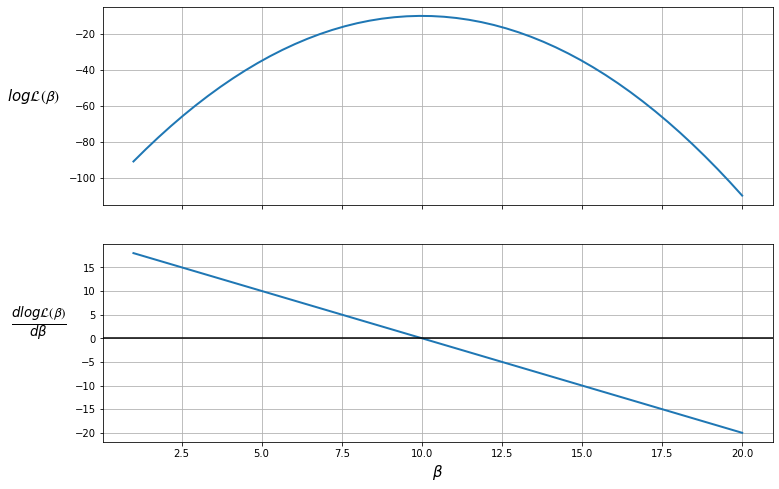

In [6]:
β = np.linspace(1, 20)
logL = -(β - 10) ** 2 - 10
dlogL = -2 * β + 20

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12, 8))

ax1.plot(β, logL, lw=2)
ax2.plot(β, dlogL, lw=2)

ax1.set_ylabel(r'$log \mathcal{L(\beta)}$',
               rotation=0,
               labelpad=35,
               fontsize=15)
ax2.set_ylabel(r'$\frac{dlog \mathcal{L(\beta)}}{d \beta}$ ',
               rotation=0,
               labelpad=35,
               fontsize=19)
ax2.set_xlabel(r'$\beta$', fontsize=15)
ax1.grid(), ax2.grid()
plt.axhline(c='black')
plt.show()

La gráfica muestra que el valor de máxima verosimilitud (la gráfica superior) ocurre cuando $\frac{d log(L(\beta|\cdot))}{d \beta} = 0$ (la gráfica inferior).

Por lo tanto, la probabilidad se maximiza cuando $\beta = 10$.

También podemos asegurarnos de que este valor sea un máximo (en oposición a un mínimo) comprobando que la segunda derivada (pendiente del gráfico inferior) es negativa.

El algoritmo de Newton-Raphson encuentra un punto donde la primera derivada es 0.

Para usar el algoritmo, hacemos una suposición inicial en el valor máximo, $\beta_0$ (las estimaciones del parámetro OLS pueden ser una suposición razonable), luego

1. Use la regla de actualización para iterar el algoritmo

$$\beta_{k+1} = \beta_k - H^{-1}(\beta_k)\cdot G(\beta_k)$$

donde:

$$G(\beta_k) = \frac{d log(L(\beta_k|\cdot))}{d \beta(k)}$$

$$H(\beta_k) = \frac{d^2 log(L(\beta_k|\cdot))}{d \beta_k d\beta_k^{'}}$$

2. Chequear que $\beta_{k+1} - \beta_k \leq  tol$

    1. Si es **Verdad**, entonces detener la iteracion y sea $\tilde{\beta} = \beta_{k+1}$
    2. Si es **Falso**, entonces actualizar $k = k+1$, e ir al paso 1.
    

Como se puede ver en la ecuación de actualización, $\beta_{k + 1} = \beta_k$ solo cuando $G(\beta_k) = 0$, es decir, donde la primera derivada es igual a 0.

(En la práctica, dejamos de iterar cuando la diferencia está por debajo de un umbral de tolerancia pequeño)

Intentemos implementar el algoritmo Newton-Raphson.

Primero, crearemos una clase llamada PoissonRegression para que podamos volver a calcular fácilmente los valores de la log-verosimilitud, gradiente y hessiano para cada iteración

In [7]:
class PoissonRegression:

    def __init__(self, y, X, β):
        self.X = X
        self.n, self.k = X.shape
        # Reshape y as a n_by_1 column vector
        self.y = y.reshape(self.n,1)
        # Reshape β as a k_by_1 column vector
        self.β = β.reshape(self.k,1)

    def μ(self):
        return np.exp(self.X @ self.β)

    def logL(self):
        y = self.y
        μ = self.μ()
        return np.sum(y * np.log(μ) - μ - np.log(factorial(y)))

    def G(self):
        y = self.y
        μ = self.μ()
        return X.T @ (y - μ)

    def H(self):
        X = self.X
        μ = self.μ()
        return -(X.T @ (μ * X))

Nuestra función *newton_raphson* tomará un objeto *PoissonRegression* que tiene una conjetura inicial del vector de parámetros $\beta_0$.

El algoritmo actualizará el vector de parámetros de acuerdo con la regla de actualización y volverá a calcular el gradiente y la matriz hessiana en las nuevas estimaciones de parámetros.

La iteración terminará cuando:

1. La diferencia entre el parámetro y el parámetro actualizado está por debajo de un nivel de tolerancia.
2. Se ha alcanzado el número máximo de iteraciones (lo que significa que no se logra la convergencia).

Para que podamos tener una idea de lo que sucede mientras se ejecuta el algoritmo, se agrega una opción *display = True* para imprimir valores en cada iteración.

In [8]:
def newton_raphson(model, tol=1e-8, max_iter=1000, display=True):

    i = 0
    error = 100  # Initial error value

    # Print header of output
    if display:
        header = f'{"Iteration_k":<13}{"Log-likelihood":<16}{"β":<30}{"Error":<30}'
        print(header)
        print("-" * len(header))

    # While loop runs while any value in error is greater
    # than the tolerance until max iterations are reached
    while np.any(error > tol) and i < max_iter:
        H, G = model.H(), model.G()
        β_new = model.β - (np.linalg.inv(H) @ G)
        error = β_new - model.β
        model.β = β_new

        # Print iterations
        if display:
            β_list = [f'{t:.3}' for t in list(model.β.flatten())]
            error_list = [f'{t:.6}' for t in list([error[0][0],error[1][0],error[2][0]])]
            update = f'{i:<13}{model.logL():<16.8}{β_list}{error_list}'
            print(update)

        i += 1

    print(f'Number of iterations: {i}')
    print(f'β_hat = {model.β.flatten()}')

    # Return a flat array for β (instead of a k_by_1 column vector)
    return model.β.flatten()

Probemos nuestro algoritmo con un pequeño conjunto de datos de 5 observaciones y 3 variables en X.

In [9]:
X = np.array([[1, 2, 5],
              [1, 1, 3],
              [1, 4, 2],
              [1, 5, 2],
              [1, 3, 1]])

y = np.array([1, 0, 1, 1, 0])

# Take a guess at initial βs
init_β = np.array([0.1, 0.1, 0.1])

# Create an object with Poisson model values
poi = PoissonRegression(y, X, β=init_β)

# Use newton_raphson to find the MLE
β_hat = newton_raphson(poi, display=True)

Iteration_k  Log-likelihood  β                             Error                         
-----------------------------------------------------------------------------------------
0            -4.3447622      ['-1.49', '0.265', '0.244']['-1.589', '0.164804', '0.143817']
1            -3.5742413      ['-3.38', '0.528', '0.474']['-1.89494', '0.263008', '0.230266']
2            -3.3999526      ['-5.06', '0.782', '0.702']['-1.6805', '0.253781', '0.22767']
3            -3.3788646      ['-5.92', '0.909', '0.82']['-0.850684', '0.127576', '0.118588']
4            -3.3783559      ['-6.07', '0.933', '0.843']['-0.15878', '0.0235561', '0.0223095']
5            -3.3783555      ['-6.08', '0.933', '0.843']['-0.00458304', '0.000677295', '0.000645471']
6            -3.3783555      ['-6.08', '0.933', '0.843']['-3.67882e-06', '5.43265e-07', '5.18376e-07']
7            -3.3783555      ['-6.08', '0.933', '0.843']['-2.36788e-12', '3.49609e-13', '3.33733e-13']
Number of iterations: 8
β_hat = [-6.07848573  0.9

Como se trataba de un modelo simple con pocas observaciones, el algoritmo logró la convergencia en solo 7 iteraciones.

Puede ver que con cada iteración, el valor de la log-verosimilitud aumenta.

Recuerde, nuestro objetivo era maximizar la función de la log-verosimilitud, por lo tanto el algoritmo funciona y alcanza el objetivo.

Además, tenga en cuenta que el aumento en $log L(\beta_k|\cdot)$ se vuelve más pequeño con cada iteración.

Esto se debe a que el gradiente se acerca a 0 cuando alcanzamos el máximo y, por lo tanto, el numerador en nuestra ecuación de actualización se está volviendo más pequeño.

El vector de gradiente debe estar cerca de 0 en $\tilde{\beta}$

In [10]:
poi.G()

array([[-1.48492330e-15],
       [-4.77395901e-15],
       [-4.70457007e-15]])

Volviendo a nuestro analisis

In [11]:
# creo una tabla solo con el año objetivo

df = df[df['year'] == 2008]

In [12]:
# hay que hacer una limpieza de los datos faltantes

np.isnan(df[['numbil0','lngdppc','lnpop','gattwto08']]).any(axis=1)

18      False
44      False
70      False
95      False
120     False
        ...  
5321     True
5349     True
5374    False
5400    False
5425    False
Length: 213, dtype: bool

In [13]:
# elimino todas las filas de las columnas interes que contengan datos faltantes

df_new = df[~np.isnan(df[['numbil0','lngdppc','lnpop','gattwto08']]).any(axis=1)]

In [14]:
# agrego una columna de 1 para la constante β_0

df_new['const'] = 1

C:\Users\esnil\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
df_new

,country,ccode,year,cyear,numbil,...,rintr,noyrs,roflaw,nrrents,const
18,United States,2.0,2008.0,22008.0,469.0,...,4.988405,20.0,1.61,2.520018,1
44,Canada,20.0,2008.0,202008.0,25.0,...,4.581436,20.0,1.80,8.943757,1
70,"Bahamas, The",31.0,2008.0,312008.0,NaN,...,3.351326,20.0,1.19,0.033702,1
95,Aruba,32.0,2008.0,322008.0,NaN,...,8.097019,13.0,0.89,0.003368,1
120,Bermuda,33.0,2008.0,332008.0,NaN,...,NaN,0.0,0.89,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...
5271,"Micronesia, Fed. Sts.",987.0,2008.0,9872008.0,NaN,...,13.750373,13.0,0.41,0.040276,1
5296,Samoa,990.0,2008.0,9902008.0,NaN,...,7.786314,6.0,0.80,0.620149,1
5374,"Hong Kong SAR, China",1001.0,2008.0,10012008.0,26.0,...,5.520900,18.0,1.48,0.001568,1
5400,Puerto Rico,1002.0,2008.0,10022008.0,NaN,...,NaN,0.0,0.59,0.000000,1


In [16]:
# arreglo la matriz X y el vector y, que se usan como entrada al algoritmo

X = df_new.loc[:,['const','lngdppc', 'lnpop', 'gattwto08']]
y = df_new["numbil0"]

In [17]:
X = X.to_numpy()
y = y.to_numpy()
init_β = np.array([0.1,0.1,0.1,0.1])

In [18]:
# Create an object with Poisson model values
poi = PoissonRegression(y, X, β=init_β)

# Use newton_raphson to find the MLE
β_hat = newton_raphson(poi, display=True)

Iteration_k  Log-likelihood  β                             Error                         
-----------------------------------------------------------------------------------------
0            -inf            ['-0.942', '0.103', '0.104', '0.0993']['-1.04185', '0.00250053', '0.00362377']
1            -inf            ['-2.06', '0.109', '0.113', '0.0975']['-1.11383', '0.00675268', '0.00976457']
2            -inf            ['-3.37', '0.127', '0.139', '0.0929']['-1.30973', '0.0180327', '0.0259215']
3            -inf            ['-5.21', '0.174', '0.205', '0.0816']['-1.84025', '0.0467381', '0.0661224']
4            -inf            ['-8.42', '0.286', '0.358', '0.0595']['-3.21008', '0.112082', '0.15214']
5            -inf            ['-14.3', '0.508', '0.631', '0.0314']['-5.91404', '0.221438', '0.273922']
6            -inf            ['-21.9', '0.789', '0.932', '0.0139']['-7.5274', '0.281752', '0.300018']
7            -inf            ['-27.0', '0.993', '1.11', '0.00802']['-5.1282', '0.203374'

Tenga en cuenta que nuestra implementación del algoritmo Newton-Raphson es bastante básica; para implementaciones más robustas, consulte, por ejemplo, *scipy.optimize*.

# Estimación de máxima verosimilitud con statsmodels

Ahora que sabemos lo que sucede en la practica, podemos aplicar MLE a aplicaciones interesantes.

Utilizaremos el modelo de regresión de Poisson en *statsmodels* para obtener una salida más rica con errores estándar, valores de prueba y más.

*statsmodels* utiliza el mismo algoritmo que el anterior para encontrar las estimaciones de máxima verosimilitud.

Antes de comenzar, volvamos a estimar nuestro modelo simple con *statsmodels* para confirmar que obtenemos los mismos coeficientes y el mismo valor de la log-verosimilitud.

In [20]:
X = np.array([[1, 2, 5],
              [1, 1, 3],
              [1, 4, 2],
              [1, 5, 2],
              [1, 3, 1]])

y = np.array([1, 0, 1, 1, 0])

stats_poisson = Poisson(y, X).fit()
print(stats_poisson.summary())

Optimization terminated successfully.
         Current function value: 0.675671
         Iterations 7
                          Poisson Regression Results                          
Dep. Variable:                      y   No. Observations:                    5
Model:                        Poisson   Df Residuals:                        2
Method:                           MLE   Df Model:                            2
Date:                Fri, 19 Jun 2020   Pseudo R-squ.:                  0.2546
Time:                        10:44:59   Log-Likelihood:                -3.3784
converged:                       True   LL-Null:                       -4.5325
Covariance Type:            nonrobust   LLR p-value:                    0.3153
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.0785      5.279     -1.151      0.250     -16.425       4.268
x1             0.9334      0.

Ahora reproduzcamos los resultados del artículo de Daniel Treisman, Los multimillonarios de Rusia, mencionados anteriormente en la conferencia.

Treisman comienza estimando la ecuación (1), donde:

1. $y_i$ es número de $multimillonarios_i$
2. $x_{i1}$ es log GDP per $capita_i$
3. $x_{i2}$ es log $population_i$
4. $x_{i3}$ son años en el $GATT_i$: años de membresía en el GATT y la OMC (para proporcionar acceso a los mercados internacionales)

El documento solo considera el año 2008 para su estimación.

Configuraremos nuestras variables para la estimación de esta manera (debe tener los datos asignados a df de antes en la conferencia)

In [21]:
df = pd.read_stata('https://github.com/QuantEcon/lecture-source-py/blob/master/source/_static/lecture_specific/mle/fp.dta?raw=true')

# Keep only year 2008
df = df[df['year'] == 2008]

# Add a constant
df['const'] = 1

# Variable sets
reg1 = ['const', 'lngdppc', 'lnpop', 'gattwto08']
reg2 = ['const', 'lngdppc', 'lnpop',
        'gattwto08', 'lnmcap08', 'rintr', 'topint08']
reg3 = ['const', 'lngdppc', 'lnpop', 'gattwto08', 'lnmcap08',
        'rintr', 'topint08', 'nrrents', 'roflaw']

Entonces podemos usar la función de Poisson de *statsmodels* para ajustar el modelo.

Utilizaremos errores estándar robustos como en el artículo del autor

In [23]:
# Specify model
poisson_reg = sm.Poisson(df[['numbil0']], df[reg1],
                         missing='drop').fit(cov_type='HC0')
print(poisson_reg.summary())

Optimization terminated successfully.
         Current function value: 2.226090
         Iterations 9
                          Poisson Regression Results                          
Dep. Variable:                numbil0   No. Observations:                  197
Model:                        Poisson   Df Residuals:                      193
Method:                           MLE   Df Model:                            3
Date:                Fri, 19 Jun 2020   Pseudo R-squ.:                  0.8574
Time:                        10:47:42   Log-Likelihood:                -438.54
converged:                       True   LL-Null:                       -3074.7
Covariance Type:                  HC0   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -29.0495      2.578    -11.268      0.000     -34.103     -23.997
lngdppc        1.0839      0.

¡Éxito! El algoritmo fue capaz de lograr la convergencia en 9 iteraciones.

Nuestra producción indica que el PIB per cápita, la población y los años de membresía en el Acuerdo General sobre Aranceles Aduaneros y Comercio (GATT) están positivamente relacionados con el número de multimillonarios que tiene un país, como se esperaba.

También vamos a estimar los modelos más completos del autor y mostrarlos en una sola tabla

In [26]:
regs = [reg1, reg2, reg3]
reg_names = ['Model 1', 'Model 2', 'Model 3']
info_dict = {'Pseudo R-squared': lambda x: f"{x.prsquared:.2f}",
             'No. observations': lambda x: f"{int(x.nobs):d}"}
regressor_order = ['const',
                   'lngdppc',
                   'lnpop',
                   'gattwto08',
                   'lnmcap08',
                   'rintr',
                   'topint08',
                   'nrrents',
                   'roflaw']
results = []

for reg in regs:
    result = sm.Poisson(df[['numbil0']], df[reg],
                        missing='drop').fit(cov_type='HC0',
                                            maxiter=100, disp=1)
    results.append(result)

results_table = summary_col(results=results,
                            float_format='%0.3f',
                            stars=True,
                            model_names=reg_names,
                            info_dict=info_dict,
                            regressor_order=regressor_order)
results_table.add_title('Table 1 - Explaining the Number of Billionaires \
                        in 2008')
print(results_table)

Optimization terminated successfully.
         Current function value: 2.226090
         Iterations 9
Optimization terminated successfully.
         Current function value: 1.982676
         Iterations 9
Optimization terminated successfully.
         Current function value: 1.954384
         Iterations 9
Table 1 - Explaining the Number of Billionaires                         in 2008
                  Model 1    Model 2    Model 3  
-------------------------------------------------
const            -29.050*** -19.444*** -20.858***
                 (2.578)    (4.820)    (4.255)   
lngdppc          1.084***   0.717***   0.737***  
                 (0.138)    (0.244)    (0.233)   
lnpop            1.171***   0.806***   0.929***  
                 (0.097)    (0.213)    (0.195)   
gattwto08        0.006      0.007      0.004     
                 (0.007)    (0.006)    (0.006)   
lnmcap08                    0.399**    0.286*    
                            (0.172)    (0.167)   
rintr         

El resultado sugiere que la frecuencia de los multimillonarios se correlaciona positivamente con el PIB per cápita, el tamaño de la población, la capitalización bursátil y se correlaciona negativamente con la tasa impositiva marginal más alta.

Para analizar nuestros resultados por país, podemos trazar la diferencia entre los valores predichos y reales, luego ordenar de mayor a menor y graficar los primeros 15

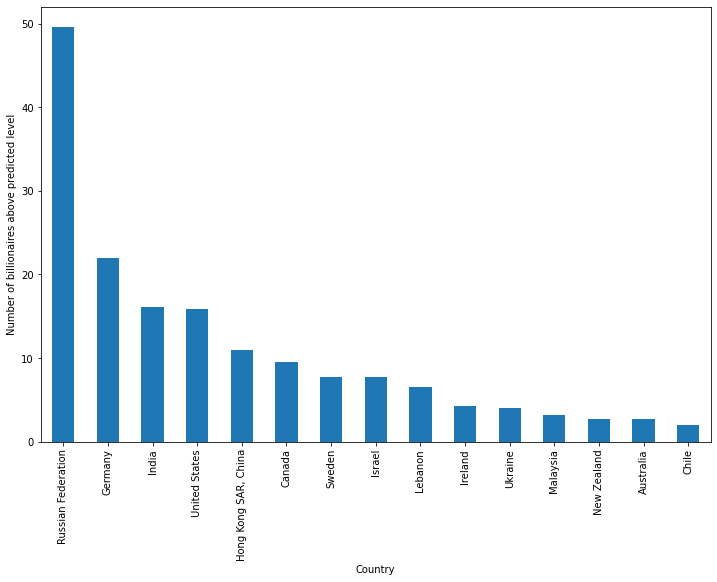

In [27]:
data = ['const', 'lngdppc', 'lnpop', 'gattwto08', 'lnmcap08', 'rintr',
        'topint08', 'nrrents', 'roflaw', 'numbil0', 'country']
results_df = df[data].dropna()

# Use last model (model 3)
results_df['prediction'] = results[-1].predict()

# Calculate difference
results_df['difference'] = results_df['numbil0'] - results_df['prediction']

# Sort in descending order
results_df.sort_values('difference', ascending=False, inplace=True)

# Plot the first 15 data points
results_df[:15].plot('country', 'difference', kind='bar',
                    figsize=(12,8), legend=False)
plt.ylabel('Number of billionaires above predicted level')
plt.xlabel('Country')
plt.show()

Como podemos ver, Rusia tiene, con mucho, el mayor número de multimillonarios en exceso de lo que predice el modelo (alrededor de 50 más de lo esperado).

Treisman utiliza este resultado empírico para discutir las posibles razones del exceso de multimillonarios de Rusia, incluido el origen de la riqueza en Rusia, el clima político y la historia de la privatización en los años posteriores a la USSR.

In [28]:
def newton(f,Df,x0,epsilon,max_iter):
    '''Approximate solution of f(x)=0 by Newton's method.

    Parameters
    ----------
    f : function
        Function for which we are searching for a solution f(x)=0.
    Df : function
        Derivative of f(x).
    x0 : number
        Initial guess for a solution f(x)=0.
    epsilon : number
        Stopping criteria is abs(f(x)) < epsilon.
    max_iter : integer
        Maximum number of iterations of Newton's method.

    Returns
    -------
    xn : number
        Implement Newton's method: compute the linear approximation
        of f(x) at xn and find x intercept by the formula
            x = xn - f(xn)/Df(xn)
        Continue until abs(f(xn)) < epsilon and return xn.
        If Df(xn) == 0, return None. If the number of iterations
        exceeds max_iter, then return None.

    Examples
    --------
    >>> f = lambda x: x**2 - x - 1
    >>> Df = lambda x: 2*x - 1
    >>> newton(f,Df,1,1e-8,10)
    Found solution after 5 iterations.
    1.618033988749989
    '''
    xn = x0
    for n in range(0,max_iter):
        fxn = f(xn)
        if abs(fxn) < epsilon:
            print('Found solution after',n,'iterations.')
            return xn
        Dfxn = Df(xn)
        if Dfxn == 0:
            print('Zero derivative. No solution found.')
            return None
        xn = xn - fxn/Dfxn
        print(xn)
    print('Exceeded maximum iterations. No solution found.')
    return None

p = lambda x: -2 * x + 20
Dp = lambda x: -2
approx = newton(p,Dp,1,1e-10,100)
print(approx)

10.0
Found solution after 1 iterations.
10.0


In [29]:
import numpy as np
from scipy.optimize import minimize

def ejemplo(x):
    return (x - 10) ** 2 + 10

def ejemplo_df(x):
    return 2 * x - 20

x0 = np.array([1])

res = minimize(ejemplo, x0, method='BFGS', jac=ejemplo_df,options={'disp': True})

Optimization terminated successfully.
         Current function value: 10.000000
         Iterations: 4
         Function evaluations: 5
         Gradient evaluations: 5


# Referencias

1. https://python.quantecon.org/mle.html
2. https://www.math.ubc.ca/~pwalls/math-python/roots-optimization/newton/
3. https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html
4. https://zhiyzuo.github.io/MLE-vs-MAP/
5. http://163.117.136.247/teoria-de-la-senal-y-comunicaciones/teoria-moderna-de-la-deteccion-y-estimacion-2013/apuntes/apuntesb1.pdf
5. https://fhernanb.github.io/Manual-de-R/loglik.html#m%C3%A9todo-de-m%C3%A1xima-verosimilitud-para-estimar-par%C3%A1metros